Phase 4 Project - Kaggle Competition "Natural Language Processing with Disaster Tweets"

In [1]:
Sentiment Classification on twitter data

SyntaxError: invalid syntax (<ipython-input-1-42ca114ec4a9>, line 1)

## Business Problem

Data has been accumulated from a number of tweets, some of which are about disasters, some of which are not. By creating a model for Natural Language Processing (NLP), we can predict whether or not a given tweet is about a real disaster or not. This can benefit companies who wish to monitor twitter in the event of an emergency.

## Data Understanding

Necessary imports:


In [2]:
import pandas as pd 
import numpy as np 
np.random.seed(42)
import nltk
nltk.download('punkt')
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from nltk import FreqDist
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolemichaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Data Exploration:

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
# I won't be working with the 'location' column, so I'll just drop that.
train_df = train_df.drop(columns = ['location'])
test_df = test_df.drop(columns = ['location'])
train_df.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df['text'].dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7613 non-null   int64 
 1   keyword  7552 non-null   object
 2   text     7613 non-null   object
 3   target   7613 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 238.0+ KB


In [9]:
test_df['text'].dropna(inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3263 non-null   int64 
 1   keyword  3237 non-null   object
 2   text     3263 non-null   object
dtypes: int64(1), object(2)
memory usage: 76.6+ KB


In [10]:
# Example of what is NOT a disaster tweet:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [11]:
# Example of what IS a disaster tweet:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

###### Visualizing what proportion of the training data are disaster tweets and non-disaster tweets

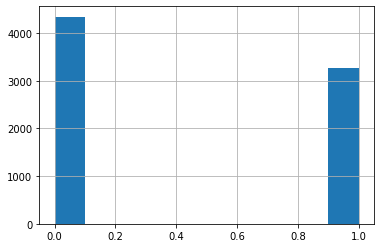

In [12]:
train_df['target'].hist();

## Data Preparation

#### Cleaning text data:
need to remove urls, tags (contain @), stopwords, punctuation, etc.

In [13]:
# Removing stopwords, punctuation, numbers, and bad characters 
# Stopwords removed during pipeline instead ? 

stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_cleaned = train_df['text'].apply(clean_text)
#train_df_cleaned = pd.DataFrame.sparse.from_spmatrix(train_df_cleaned)
test_df_cleaned = test_df['text'].apply(clean_text)
#test_df_cleaned = pd.DataFrame.sparse.from_spmatrix(test_df_cleaned)
train_df_cleaned.head(10) 




0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked 'shelter place' notified offic...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                          i'm top hill see fire woods
8    there's emergency evacuation happening buildin...
9                       i'm afraid tornado coming area
Name: text, dtype: object

___________


###### Calculating the probabilities of disaster and non-disaster tweets in the training data:

In [14]:
disaster_tweets = train_df[train_df['target']==1]

other_tweets = train_df[train_df['target']==0]

In [15]:
P_disasters = len(disaster_tweets) /(len(disaster_tweets)+len(other_tweets))
P_non = len(other_tweets) /(len(other_tweets)+len(disaster_tweets))
print(P_disasters)
print(P_non)

0.4296597924602653
0.5703402075397347


This tells us that tweets in train_df have a higher probability of not being about a disaster.

_______

In [16]:
X = train_df.text
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [29]:
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

In [17]:
# Keep this cell??
# Move to Misc.?

# Tokenizing the data:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

train_df_tokenized = train_df_cleaned.copy()
test_df_tokenized = test_df_cleaned.copy()
train_df_tokenized = train_df_cleaned.apply(tokenizer.tokenize)
test_df_tokenized = test_df_cleaned.apply(tokenizer.tokenize)


In [19]:
# Keep this cell??
# Move to Misc.?


#X_train_tokenized = X_train_cleaned.apply(tokenizer.tokenize)
#X_test_tokenized = X_test_cleaned.apply(tokenizer.tokenize)

#X_train_tokenized.explode()
#X_test_tokenized.explode()

In [20]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    


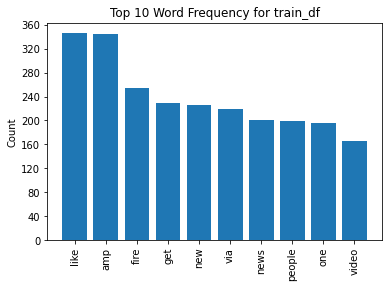

In [21]:
train_freq_dist = FreqDist(train_df_tokenized.explode())
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for train_df")

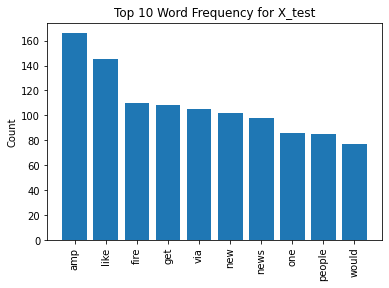

In [22]:
test_freq_dist = FreqDist(test_df_tokenized.explode())
visualize_top_10(test_freq_dist, "Top 10 Word Frequency for X_test")

Many of the most common words are the same in both the training df and the test df.

In [23]:
#Need to do this visualization for target=1 and target=0 of train_df

In [24]:
disaster_tweets_cleaned = disaster_tweets['text'].apply(clean_text)
other_tweets_cleaned = other_tweets['text'].apply(clean_text)

In [25]:
disaster_tweets_tokenized = disaster_tweets_cleaned.apply(tokenizer.tokenize)
other_tweets_tokenized = other_tweets_cleaned.apply(tokenizer.tokenize)


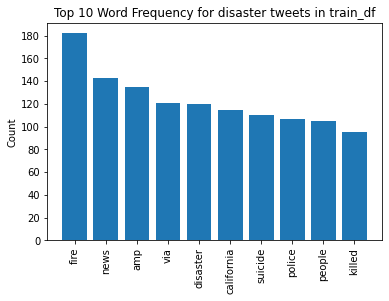

In [26]:
dis_tweets_freq_dist = FreqDist(disaster_tweets_tokenized.explode())
visualize_top_10(dis_tweets_freq_dist, "Top 10 Word Frequency for disaster tweets in train_df")

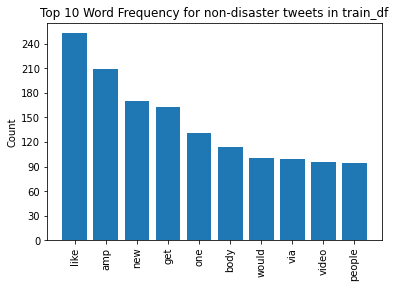

In [27]:
other_tweets_freq_dist = FreqDist(other_tweets_tokenized.explode())
visualize_top_10(other_tweets_freq_dist, "Top 10 Word Frequency for non-disaster tweets in train_df")

###### Building a baseline model

In [30]:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7980290172460991
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [31]:
# Model with bigrams:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list,
                                                   ngram_range=(1,2))),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))




/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7952741308160336
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [32]:
# model with TF-IDF Vectorizer instead of CountVectorizer

model2 = Pipeline([('vect', TfidfVectorizer(tokenizer=word_tokenize,
                                           stop_words=stopwords_list)),
                   ('clf', MultinomialNB()),
                  ])
model2.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred2 = model2.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred2, y_test, average="macro"))
print(classification_report(y_test, y_pred2))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7917740240719726
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1091
           1       0.84      0.67      0.74       813

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [33]:
#when stemming/lemmatizing, we are going to do the same to the stopwords, so we don't want to remove them before this
def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    #text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    
train_df_cleaned_nostop = train_df.copy()

train_df_cleaned_nostop['text'] = train_df_cleaned_nostop['text'].apply(clean_text_nostop)

X_nostop = train_df_cleaned_nostop.text
y_nostop = train_df_cleaned_nostop.target
X_train_nostop, X_test_nostop, y_train_nostop, y_test_nostop = train_test_split(X_nostop, y_nostop, test_size=0.25, random_state = 42)


In [34]:
# Stemming the text to see if it improves our model
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [35]:
#Stemmed data model
stem_model = Pipeline([('vect', CountVectorizer(
                         stop_words=stemmed_stopwords,
                         tokenizer=stem_and_tokenize)),
               ('clf', MultinomialNB()),
              ])
stem_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_pred_stem= stem_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_pred_stem, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_stem))

F1 0.7995784912170498
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.74      0.76       813

    accuracy                           0.81      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.81      0.81      0.80      1904



In [36]:
#What about lemmatization?
lemmatizer = WordNetLemmatizer() 

def lem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


lemm_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [37]:
# Lemmatized data model
lemm_model = Pipeline([('vect', CountVectorizer(
                         stop_words=lemm_stopwords,
                         tokenizer=lem_and_tokenize)),
                       ('clf', MultinomialNB()),
              ])
lemm_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_lemm_pred= lemm_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_lemm_pred, y_test_nostop))
print(classification_report(y_test_nostop, y_lemm_pred))

F1 0.7612412919569347
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1091
           1       0.78      0.74      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



The best model was the stemmed model.

______

#### Attempting GridSearch:

In [38]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_cleaned)
X_test_vectorized = vectorizer.transform(X_test_cleaned)

# Which do I use?? The whole train_df or just X_train?

#train_df_vectorized = tfidf.fit_transform(train_df)
#test_df_vectorized = tfidf.transform(test_df)

#pd.DataFrame.sparse.from_spmatrix(train_df_vectorized, columns=vectorizer.get_feature_names())

In [39]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train_cleaned)
X_train_vec  = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)


X_test_vec = cv.transform(X_test_cleaned)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [40]:
#GridSearchCV
alphas = [0.5, 1.0, 1.5, 2.0, 2.5]
p_grid_NB = {'alpha': alphas, 'fit_prior' : [True, False]}
NB_cls= MultinomialNB()

grid = GridSearchCV(estimator = NB_cls, param_grid = p_grid_NB, scoring = 'f1', cv = 3)
grid.fit(X_train_vec, y_train)

KeyboardInterrupt: 

Explanation for hyperparams:
- alpha specifies whether or not to use smoothing/ it is the additive smoothing parameter (0=No smoothing)

- class prior is the prior probability of the classes. Default is None.  If specified the priors are not adjusted according to the data.

- fit prior specifies whether to learn class prior probabilities or not. If false, a uniform prior will be used.

In [ ]:
grid.best_params_

In [41]:
tuned_model = Pipeline([('vect', CountVectorizer(
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    ngram_range = (1,3))),
                        ('clf', MultinomialNB(alpha= 2.0,fit_prior = True)),
              ])
tuned_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_pred_tuned= tuned_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_pred_tuned, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_tuned))

F1 0.8015542480543345
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



______

In [306]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [307]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [308]:
model = MultinomialNB()

In [309]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, y_test);

ValueError: could not convert string to float: 'So you have a new weapon that can cause un-imaginable destruction.'

In [67]:
#from sklearn.preprocessing import MultiLabelBinarizer
model4 = Pipeline([('vect', MultiLabelBinarizer()),
               #('clf', MultinomialNB()),
              #])
model4.fit(X_train, y_train)


y_pred4 = model4.predict(X_test)

#print('accuracy %s' % accuracy_score(y_pred4, y_test))
#print(classification_report(y_test, y_pred4))



## Generating Predictions

After building baseline model, try things to improve score

In [45]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [54]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


Before creating predictions on the sample submission csv, I want to try it on the test_df to make sure it works:


In [66]:
def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    return text
    
test_df_cleaned_nostop = test_df.copy()

test_df_cleaned_nostop['text'] = test_df_cleaned_nostop['text'].apply(clean_text_nostop)


In [67]:
test_df_cleaned_nostop

,id,keyword,text
0,0,NaN,just happened a terrible car crash
1,2,NaN,heard about earthquake is different cities s...
2,3,NaN,there is a forest fire at spot pond geese are...
3,9,NaN,apocalypse lighting spokane wildfires
4,11,NaN,typhoon soudelor kills in china and taiwan
...,...,...,...
3258,10861,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,storm in ri worse than last hurricane my city...
3260,10868,NaN,green line derailment in chicago
3261,10874,NaN,meg issues hazardous weather outlook hwo


In [69]:
test_df_sample = test_df_cleaned_nostop.copy()
test_df_sample['target'] = tuned_model.predict(test_df_sample['text'])

In [70]:
test_df_sample

,id,keyword,text,target
0,0,NaN,just happened a terrible car crash,1
1,2,NaN,heard about earthquake is different cities s...,1
2,3,NaN,there is a forest fire at spot pond geese are...,1
3,9,NaN,apocalypse lighting spokane wildfires,1
4,11,NaN,typhoon soudelor kills in china and taiwan,1
...,...,...,...,...
3258,10861,NaN,earthquake safety los angeles ûò safety faste...,1
3259,10865,NaN,storm in ri worse than last hurricane my city...,0
3260,10868,NaN,green line derailment in chicago,1
3261,10874,NaN,meg issues hazardous weather outlook hwo,1


In [71]:
test_df_sample['target'].value_counts()

0    2062
1    1201
Name: target, dtype: int64

This appears to have worked, so let's try it on the sample submission:

In [55]:
sample_submission["target"] = tuned_model.predict(test_df['text'])

In [56]:
sample_submission['target'].value_counts()

0    2001
1    1262
Name: target, dtype: int64

## Evaluation

## Conclusion

_____

In [257]:
df1=pd.DataFrame(X_train)
df1=df1.rename(columns={0:'tweet'})

df2=pd.DataFrame(y_train)
df2=df2.rename(columns={1:'sentiment'})

df_train=pd.concat([df1,df2],axis=1)

df3=pd.DataFrame(X_test)
df3=df3.rename(columns={0:'tweet'})

df4=pd.DataFrame(y_test)
df4=df4.rename(columns={1:'sentiment'})
df_test=pd.concat([df3,df4],axis=1)

In [258]:
df_test

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0
...,...,...
5209,Very glad that you got obliterated in X Men Fi...,0
387,Mourning notices for stabbing arson victims st...,1
4848,Mass murderer Che Guevara greeting a woman in ...,1
1032,Womens Flower Printed Shoulder Handbags Cross ...,0


In [259]:
df_train['text'] = df_train['text'].apply(lambda x:clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x:clean_text(x))

#df_test['news']= df_test['news'].apply(lambda x:remove_punctuation(x))

In [270]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
  print("bigrams:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans


In [271]:
df_train

,text,target
5151,makes sense paper beats rock paper comes wood ...,0
6351,' causes federal failure deeply structural eas...,0
3443,well chaning ipad screen fucking exploded glas...,0
7164,war drugs turned u war zone,1
7037,obama declares disaster typhoondevastated saipan,1
...,...,...
5226,many obliteration servers always like play,0
5390,panic attack bc enough money drugs alcohol wan...,0
860,omron hemc automatic blood pressure monitor st...,0
7603,officials say quarantine place alabama home po...,1


In [272]:
generate_N_grams("The sun rises in the east",2)

bigrams: ['The', 'sun', 'rises', 'east']


['The sun', 'sun rises', 'rises east']

In [273]:
from collections import defaultdict

disasterValues2=defaultdict(int)
noneValues2=defaultdict(int)
#neutralValues2=defaultdict(int)

In [274]:
for text in df_train[df_train.target==1].text:
  for word in generate_N_grams(text,2):
    disasterValues2[word]+=1

bigrams: ['war', 'drugs', 'turned', 'u', 'war', 'zone']
bigrams: ['obama', 'declares', 'disaster', 'typhoondevastated', 'saipan']
bigrams: ['flood', 'prone', 'waterways', 'westchester', 'county', 'eligible', 'millions', 'state', 'aid', 'newyork']
bigrams: ['driving', 'avalanche', 'car', 'week', 'like', 'driving', 'tank']
bigrams: ['three', 'israeli', 'soldiers', 'wounded', 'west', 'bank', 'terrorist', 'attack', 'via', 'r', 'worldnews']
bigrams: ['africanbaze', 'breaking', 'news', 'nigeria', 'flag', 'set', 'ablaze', 'aba']
bigrams: ['accident', 'injuries', 'nj', 'sb', 'cr', 'leonardville', 'rd']
bigrams: ['monsoon', 'flooding', 'kills', 'dozens', 'myanmar', 'prompting', 'calls', 'help']
bigrams: ['man', 'crushed', 'death', 'car']
bigrams: ['hiphop', 'news', 'indie', 'apollo', 'brown', '\x89ûò', '\x89ûïdetonate\x89û\x9d', 'ft', 'p', 'lt', 'href', "'"]
bigrams: ['severe', 'thunderstorm', 'warning', 'issued', 'august', 'pm', 'cdt', 'august', 'pm', 'cdt', 'nws']
bigrams: ['flooding', 'kills

bigrams: ['broken', 'fully', 'exploded']
bigrams: ['outbreak', "legionnaires'", 'disease', 'new', 'york', 'killed', 'least', 'people', '\x89ûó', 'officials', 'think', "they've", 'fo']
bigrams: ['detonate', 'feat', 'p', 'apollo', 'brown']
bigrams: ['nuke', 'please', 'target', 'hilversum', 'please', 'detonate', 'meters', 'surface']
bigrams: ['trauma', 'happen', 'anywhere', 'school', 'home', 'etc', 'time', 'learn', "abc's", 'trauma', 'parent', '\x89û']
bigrams: ['sky', 'looks', 'clear', 'smoke', 'fires', 'enjoy', 'time', 'tahoe', 'one', 'favorite', 'places']
bigrams: ['watch', 'airport', 'get', 'swallowed', 'sandstorm', 'minute']
bigrams: ['crash', 'queen', 'die', 'something', 'explode', 'knows']
bigrams: ['alabama', 'home', 'quarantined', 'possible', 'ebola', 'case', 'officials', 'say', 'quarantine', 'place', 'bluehand', 'pjnet']
bigrams: ['eric', 'clapton', 'shot', 'sheriff', 'guess', 'many', 'people', 'rioting', 'right', 'none']
bigrams: ['mtsalert', 'orange', 'amp', 'blue', 'line', 'r

bigrams: ['ee', 'recalls', 'power', 'bar', 'phone', 'chargers', 'explosion', 'burns', 'woman', '\x89ûò', 'register']
bigrams: ['chat', 'yes', 'feel', 'root', 'shame', 'found', 'rubble', 'trauma', 'ptsdchat']
bigrams: ['potus', 'strategicpatience', 'strategy', 'genocide', 'refugees', 'idp', 'internally', 'displaced', 'people', 'horror', 'etc']
bigrams: ['anyname', 'utopian', 'impulse', 'inevitably', 'ends', 'gulags', 'mass', 'murder']
bigrams: ['dreaming', 'peacefully', 'loud', 'ass', 'thunder', 'wanted', 'scare']
bigrams: ['disneyland', 'tacos', 'bomb']
bigrams: ['mini', 'heat', 'wave', 'apaz']
bigrams: ['pick', 'ground', 'swam', 'drowned', 'hit', 'bottom', 'hard', 'bounced', 'twice', 'suffice', 'time', 'around', 'different']
bigrams: ['new', 'post', 'pic', 'yr', 'old', 'pkk', 'suicide', 'bomber', 'detonated', 'bomb', 'turkey', 'army', 'trench', 'released']
bigrams: ['latest', 'homes', 'razed', 'northern', 'california', 'wildfire', 'abc', 'news']
bigrams: ['guy', 'bought', 'car', 'tues

bigrams: ['check', 'lightning', 'reshapes', 'rocks', 'atomic', 'level', 'scichat', 'science']
bigrams: ['news', 'hostages', 'libya', 'india', 'terrorism', 'africa', 'ap', 'ts', 'nri', 'news', 'trs', 'tdp', 'bjp']
bigrams: ['pray', 'east', 'coast', 'forest', 'fires', 'pray', 'put', 'pray', 'rain']
bigrams: ['poor', 'sods', 'arriving', 'amman', "yesterday's", 'dust', 'storm', 'diverted', 'ben', 'gurion', 'airport']
bigrams: ['still', 'domestic', 'terrorism']
bigrams: ['people', 'rioting', 'everywhere', 'think', "i'd", 'one', "'", 'usamisan', 'lt']
bigrams: ['angry', 'woman', 'openly', 'accuses', 'nema', 'stealing', 'relief', 'materials', 'meant', 'idps', 'angry', 'internally', 'displaced', 'wom']
bigrams: ['years', 'atomic', 'bombs', 'japan', 'still', 'struggles', 'war', 'past', 'anniversary', 'devastation', 'wrought', 'b']
bigrams: ['en', 'linked', 'arsenal', 'causes', 'injury']
bigrams: ['maratha', 'raiders', 'scorched', 'lands', 'amp', 'punjab', 'refused', 'food', 'aid', 'famine', 'wo

bigrams: ['another', 'entity', 'forced', 'close', 'montego', 'bay', 'result', 'collapsed', 'sewer', 'line', 'tvjnews']
bigrams: ['truth', 'news', 'bbc', 'cnn', 'islam', 'truth', 'god', 'isis', 'terrorism', 'quran', 'lies']
bigrams: ['\x89ûï', 'everyone', 'ahh', 'hate', 'snow', 'lol', 'u', 'call', 'snowstorm', 'growingupincolorado\x89û\x9d']
bigrams: ["'an", 'wheeler', 'came', 'along', 'struck', 'fire', 'truck', 'spinning', 'around', 'degrees', 'causing', 'roll', "over'"]
bigrams: ['fyi', 'cad', 'fyi', 'accident', 'property', 'damage', 'nhs', 'piner', 'rd', 'horndale', 'dr']
bigrams: ['ok', 'severe', 'thunderstorm', 'warning', 'issued', 'august', 'pm', 'cdt', 'august', 'pm', 'cdt', 'nws', 'okwx']
bigrams: ['sf', 'asian', "women's", 'shelter', 'crisis', 'line', 'emergency', 'shelter', 'support', 'services', 'nonenglish', 'speaking', 'asian', 'women', 'amp', 'children']
bigrams: ['reminds', 'peasants', 'destroyed', 'food', "stalin's", 'army', 'came', "'redistribute", "wealth'", 'caused', 

bigrams: ['imagine', "we're", 'inundated', 'requests', 'week', 'samples', 'amp', 'much', "we'd", 'love', 'able', 'send', 'sweets']
bigrams: ['bin', 'laden', 'family', 'plane', 'crashed', "'avoiding", 'microlight', 'landi', 'peritoengrafoscopia']
bigrams: ['stormchase', 'violent', 'record', 'breaking', 'ef', 'el', 'reno', 'oklahoma', 'tornado', 'nearly', 'runs']
bigrams: ['denali', 'wolf', 'population', 'declined', 'reinstate', 'emergency', 'buffer', 'zone', 'protectdenaliwolves']
bigrams: ['pt', 'crosssectarian', 'protest', 'powerful', 'shia', 'cleric', 'says', 'militias', 'must', 'withdraw', "'ur", 'fightin', 'isis', 'wont', 'forget', 'damage', 'uve', 'done', 'ur', "ppl'"]
bigrams: ['kirsten', 'gillibrand', 'extend', 'health', 'care', 'first', 'responders']
bigrams: ['prophet', 'peace', 'upon', 'said', "'save", 'hellfire', 'even', 'giving', 'half', 'date', 'charity', "'"]
bigrams: ['car', 'even', 'week', 'got', 'fucking', 'car', 'accident', 'mfs', "can't", 'fucking', 'drive']
bigrams:

bigrams: ['went', 'school', 'bombed', 'east', 'end', 'london', 'families', 'one', 'house', 'bathroom', 'outside', 'loo', 'amp', 'poor', 'whats', 'yr', 'point']
bigrams: ['unbelievably', 'insane', 'man', 'airport', 'airplane', 'aircraft', 'aeroplane', 'runway', 'accident', 'freaky\x89û']
bigrams: ['catastrophic', 'wild', 'fires', 'threatening', 'u', 'mid', 'west', 'amp', 'republicans', 'fighting', 'new', 'climate', 'change', 'rules', 'guess', 'ultimate', 'darwinism']
bigrams: ['news', "'islamic", 'state', 'claims', 'suicide', 'bombing', 'saudi', 'arabian', "mosque'"]
bigrams: ['made', 'anthonys', 'bed', 'considering', 'destroy', 'everytime', 'fall', 'asleep', 'smh']
bigrams: ['latest', 'homes', 'razed', 'northern', 'california', 'wildfire']
bigrams: ['rt', 'abbswinston', 'zionist', 'terrorist', 'kidnapped', 'palestinians', 'overnight', 'terror', 'palestinian', 'villages', '\x89û']
bigrams: ['recycling', 'using', 'nonhazardous', 'chemicals', 'holland', 'continually', 'strives', 'maintain

bigrams: ['carolina', 'accident', 'motorcyclist', 'dies', 'crash', 'car', 'crossed', 'median', 'motorcycle', 'rider', 'traveling']
bigrams: ['governor', 'allows', 'parole', 'school', 'bus', 'hijacker', 'via', 'remember', 'crime', 'sent', 'chills', 'parents']
bigrams: ['thought', 'drought']
bigrams: ['telnet', 'attacked', 'streamyxhomesouthern']
bigrams: ['uk', 'police', 'link', 'tunisian', 'beach', 'massacre', 'bardo', 'museum', 'attack']
bigrams: ['\x89ûï', 'burst', 'water', 'main', 'causes', 'major', 'flooding', 'birmingham', 'hospital', 'omg']
bigrams: ['watch', 'airport', 'get', 'swallowed', 'sandstorm', 'minute']
bigrams: ['latest', 'homes', 'razed', 'northerncalifornia', 'wildfire', 'zippednews']
bigrams: ['suicide', 'bomber', 'kills', 'saudi', 'security', 'site', 'mosque', 'reuters']
bigrams: ['pakistan', 'disowned', 'kasab', 'disowns', 'naved', 'state', 'denial', 'naved', 'terrorist', 'captured', 'alive', 'an\x89û']
bigrams: ['check', 'udhampur', 'terror', 'attack', 'militants'

bigrams: ['deai', 'suicide', 'bomber', 'kills', 'saudi', 'security', 'site', 'mosque', 'reuters']
bigrams: ["'without", 'bombing', 'would', 'harakiri', 'know', 'commit', "suicide'", 'hiroshima', 'years', 'ago']
bigrams: ['sydney', 'hostage', 'crisis', 'recovered', 'airasia', 'wreckage']
bigrams: ['watch', 'airport', 'get', 'swallowed', 'sandstorm', 'minute']
bigrams: ['catastrophe', 'anything', 'literally', 'unable', 'stop', 'ejaculating']
bigrams: ['removing', 'tsunami', 'debris', 'west', 'coast', 'karen', 'robinson', 'enviromental', 'emergency', 'services', 'manager', 'the\x89û']
bigrams: ['bbc', 'news', 'india', 'rail', 'crash', 'trains', 'derail', 'madhya', 'pradesh', 'flash', 'flood']
bigrams: ['bbsnews', 'latest', 'palestine', 'amp', 'israel', 'six', 'palestinians', 'kidnapped', 'west', 'bank', 'hebron', 'home', 'demolished']
bigrams: ['trafford', 'centre', 'film', 'fans', 'angry', 'odeon', 'cinema', 'evacuated', 'following', 'false', 'fire', 'alarm']
bigrams: ['baltimore', 'city

bigrams: ['explosion', 'gaza', 'strip', 'kills', 'four', 'wounds', 'cause', 'unknown', 'via']
bigrams: ['ohh', 'bush', 'fires', 'spain', 'like', 'every', 'year', 'one', 'time', 'went', 'swimming', 'planes', 'getting', 'water', 'fight']
bigrams: ['obama', 'declares', 'disaster', 'typhoondevastated', 'saipan', 'obama', 'signs', 'disaster', 'declaration', 'northern', 'marians']
bigrams: ['trafford', 'centre', 'film', 'fans', 'angry', 'odeon', 'cinema', 'evacuated', 'following', 'false', 'fire', 'alarm', 'twitter', 'users', 'tell', 'of\x89û']
bigrams: ['boy', 'charged', 'manslaughter', 'shooting', 'death', 'elijah', 'walker']
bigrams: ['usgs', 'reports', 'earthquake', 'km', 'volcano', 'hawaii', 'utc', 'quake']
bigrams: ['radioactive', 'box', 'quarantined', 'israel\x89ûªs', 'ashdod', 'port', 'evacuated', 'emergency', 'teams', 'discovered', 'radiation', 'emittin']
bigrams: ['mention', 'major', 'contributor', 'annihilation', 'israel']
bigrams: ['murderous', 'story', 'america\x89ûªs', 'first',

bigrams: ['another', 'white', 'mass', 'murderer', 'thank', 'god', "i'm", 'california']
bigrams: ['emergency', 'flow', 'mp', 'rar']
bigrams: ['strong', 'thunderstorm', 'miles', 'east', 'pickens', 'moving', 'ne', 'mph', 'pea', 'size', 'hail', 'wind', 'gusts', 'mph', 'scwx']
bigrams: ['chick', 'masturbates', 'guy', 'gets', 'exploded', 'face', 'gt']
bigrams: ['standard', 'damage', 'control']
bigrams: ['e', 'particulate', 'break', 'solid', 'combust', 'fossil', 'fuel', 'voltaic', 'active', 'forest', 'fire', 'biological', 'voc', 'petroleum', 'ch', 'bacteria', 'decomposition']
bigrams: ['says', 'nd', 'grenade', 'found', "'younger'", 'wwii', 'era', 'grenade', 'found', 'earlier', "they'll", 'detonate', 'tonight']
bigrams: ['mad', 'catastrophe', 'outbreak', 'world', 'war', 'collapse']
bigrams: ['police', 'chief', 'assured', 'crowd', 'officerrelated', 'shooting', 'would', 'investigated']
bigrams: ['obama', 'declares', 'disaster', 'typhoondevastated', 'saipan', 'obama', 'signs', 'disaster', 'declar

bigrams: ['bbc', 'forced', 'retract', 'false', 'claims', 'cyclone', 'pam', 'via']
bigrams: ['rt', 'america', 'rt', 'rt', 'com', 'eye', 'super', 'typhoon', 'soudelor', 'seen', 'space', 'timelapse']
bigrams: ['phillips', 'charged', 'assisting', 'terrorism', "ldnrterrorists'", 'organizations']
bigrams: ["'jet", 'fuel', 'cant', 'melt', "steel'", "'the", 'structural', 'failure', "illogical'", "'the", 'second', 'plane', 'crashing', 'building', "fake'", "'it", "bomb'"]
bigrams: ['family', 'members', 'osama', 'bin', 'laden', 'died', 'airplane', 'accident', 'ironic', 'mhmmm', 'gov', 'shit', 'suspect']
bigrams: ['njturnpike', 'å', 'njturnpike', 'reopens', 'hours', 'truck', 'fire']
bigrams: ['cryptic', 'words', 'guided', 'pilots', 'hiroshima', 'bombing', 'mission', 'canada']
bigrams: ['eu', 'states', 'squabble', 'immigration', 'ukfrance', 'eurotunnel', 'deluged', 'migrants', 'one', 'dead', "'thousands", "storm'", 'tunnel']
bigrams: ['cleared', 'crash', 'hamilton', 'south', 'mm']
bigrams: ['breaki

bigrams: ['years', 'atomic', 'bombs', 'japan', 'still', 'struggles', 'war', 'past', 'anniversary', 'devastation', 'wrought', 'b']
bigrams: ['latest', 'wildfire', 'destroys', 'homes', 'crews', 'advance', 'wqow', 'tv', 'news']
bigrams: ['ok', 'ok', 'okayyyyyy', 'ima', 'act', 'right', 'bout', 'get', 'blizzard', 'tho']
bigrams: ['report', 'corey', 'brewer', 'drug', 'tested', 'point', 'explosion']
bigrams: ['missing', 'jet\x89ûªs', 'debris', 'could', 'floated', 'rì©union', 'new', 'york', 'times']
bigrams: ['like', 'shedid', 'public', 'facts', 'journalist', "bush's", 'washard', 'stopping', 'terrorist']
bigrams: ['relaxinpr', 'miprv', 'rt', 'latimes', 'arson', 'suspect', 'linked', 'fires', 'caught', 'northern', 'california']
bigrams: ['beach', 'damage', 'shit']
bigrams: ['pm', 'abe', 'pledged', 'make', 'every', 'effort', 'seek', 'world', 'without', 'nuclear', 'weapons']
bigrams: ['landslide', 'italian', 'alps', 'kills', 'three', 'rome', 'reuters', 'three', 'people', 'killed', 'severe', 'rains

bigrams: ['firefighters', 'make', 'gains', 'rockyfire', 'jerry', 'brown', 'heading', 'area', 'meet', 'first', 'responders', 'tomorrow', 'morning']
bigrams: ['udhampuragain', 'terrorist', 'shot', 'dead', 'udhampur']
bigrams: ['watch', 'airport', 'get', 'swallowed', 'sandstorm', 'minute']
bigrams: ['watch', 'airport', 'get', 'swallowed', 'sandstorm', 'minute']
bigrams: ['wreckage', "'conclusively", "confirmed'", 'mh', 'malaysia', 'pm', 'investigators', 'families']
bigrams: ['death', 'railway', 'track', 'rains', 'cannot', 'take', 'blame', 'derailment', 'common', 'last', 'year', 'less', 'th']
bigrams: ['omfg', 'didnt', 'expect', 'drag', 'first', 'song', 'pandora', 'played', 'omfg', 'screamed', 'loud', 'coworker', 'scared']
bigrams: ['omg', 'believe', 'rip', 'bro', 'airplane', 'accident', 'jetengine', 'turbojet', 'boing', 'g']
bigrams: ['stemming', 'cubs', 'talk', 'team', 'rosters', 'cancer', 'survivors', 'amp', 'fans', 'help', 'another']
bigrams: ['bomb', 'head', 'explosive', 'decisions', 

bigrams: ['look', 'state', 'actions', 'year', "ferguson's", 'upheaval']
bigrams: ['looks', 'like', 'war', 'zone', 'outside', "what's", 'going']
bigrams: ['parents', 'colorado', 'theater', 'shooting', 'victim', 'fear', 'copycat', 'massacre', 'antioch']
bigrams: ['sismo', 'detectado', 'japì', 'n', 'miyagi', 'estimated', 'seismic', 'intensity', 'jst']
bigrams: ['california', 'fires', 'rage', 'forest', 'service', 'sounds', 'alarm', 'rising', 'wildfire', 'costs']
bigrams: ['hope', 'hope', 'die', 'explosion']
bigrams: ['scene', 'derailment', 'cta', 'green', 'line', 'rd', 'prairie']
bigrams: ['fireman', 'ed', 'runs', 'burning', 'buildings', 'others', 'running', 'doug', 'deserves', 'respect']
bigrams: ['catastrophic', 'effects', 'hiroshima', 'nagasaki', 'atomic', 'bombings', 'still', 'felt', 'today']
bigrams: ['turkish', 'troops', 'killed', 'kurdish', 'militant', "'suicide", "attack'"]
bigrams: ['\x89ûï', 'leo', 'caption', 'needed', 'freshman', 'nigga', 'stacey', 'body', 'bagging', 'niggas']
b

bigrams: ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']
bigrams: ['obama', 'declares', 'disaster', 'typhoondevastated', 'saipan', 'president', 'barack', 'obama', 'declared', 'commonwealth']
bigrams: ['tnn', "china's", 'stock', 'market', 'crash', 'gems', 'rubble']
bigrams: ['knight', 'rescuers', 'searching', 'hundreds', 'migrants', 'mediterranean', 'boat', 'carr']
bigrams: ['consent', 'order', 'cleanup', 'underway', 'csx', 'derailment', 'site', 'knoxville', 'news', 'sentinel']
bigrams: ['investigators', 'rule', 'catastrophic', 'structural', 'failure', 'resulted', 'virg', 'related', 'articles']
bigrams: ['alleged', 'driver', 'kuwait', 'attack', "'joined", 'daesh', 'day', 'june', 'suicide', "bombing'", 'confesses', 'court']
bigrams: ['kindermorgan', 'gas', 'explosion']
bigrams: ['ok', 'peace', 'hope', 'fall', 'cliff', 'along', 'dignity']
bigrams: ['airplane', 'accident']
bigrams: ['italy', 'three', 'dead', 'landslide', 'italian', 'alps', 'via']
bigrams: ['trending', 'nigeria'

bigrams: ['eau', 'claire', 'man', 'police', 'said', 'drunk', 'suv', 'collided', 'train', 'sentenced', 'chippewa', 'county']
bigrams: ['ibrahimmisau', 'faan', 'orders', 'evacuation', 'abandoned', 'aircraft', 'mma', 'via', 'twitter']
bigrams: ['offers', 'deluxe', 'toilet', 'safety', 'support', 'health', 'home', 'bathroom', 'support', 'elderly', 'injured', 's\x89û']
bigrams: ['video', "'we're", 'picking', 'bodies', "water'", 'rescuers', 'searching', 'hundreds', 'migrants', 'africa', 'news']
bigrams: ['families', 'sue', 'legionnaires', 'families', 'affected', 'fatal', 'outbreak', "legionnaires'", 'disea']
bigrams: ['heavy', 'rainfall', 'flooding', 'northern', 'vietnam', 'situation', 'report']
bigrams: ['watching', 'streams', 'bad', 'think', 'could', 'actually', 'walk', "i'd", 'panic', 'get', 'sick']
bigrams: ['stephen', 'ave', 'flower', 'pots', 'got', 'little', 'ripped', 'hailstorm', 'today', 'yyc', 'abstorm', 'calgary', 'iamdowntown']
bigrams: ['new', 'ladies', 'shoulder', 'tote', 'handba

bigrams: ["'kessler", "syndrome'", 'name', 'catastrophic', 'exponential', 'proliferation', 'space', 'debris', 'destruction', 'satellites', 'gravitymovie']
bigrams: ['dw', 'hundreds', 'feared', 'drowned', 'migrant', 'boat', 'capsizes', 'libya', 'hundreds', 'migrants', 'are\x89û']
bigrams: ['caution', 'breathing', 'may', 'hazardous', 'health']
bigrams: ['support', 'sys', 'auth', 'taken', 'hostage', 'blk', 'us', 'clergyforced', 'exist', 'younger', 'amp', 'grossly', 'disfigured', 'bioterrorism']
bigrams: ['islamic', 'state', 'group', 'egypt', 'threatens', 'kill', 'croat', 'hostage']
bigrams: ['dude', 'smoking', 'fucking', 'thing', 'went', 'flames', 'though', 'bomb', 'went', 'omg', 'scared']
bigrams: ['latestnews', 'tension', 'bayelsa', 'patience', 'jonathan', 'plans', 'hijack', 'apc', 'pdp']
bigrams: ['one', 'man', 'fatally', 'shot', 'another', 'wounded', 'vermont', 'street', 'buffalo']
bigrams: ['granted', 'like', 'half', 'town', 'floods', 'rains', 'still', 'whatever']
bigrams: ['r', "i'm

bigrams: ['closest', 'structure', 'hypo', 'centre', 'completely', 'obliterated']
bigrams: ['science', 'piece', 'wreckage', 'flight', 'mh', 'confirmed', 'rì©union', 'island', 'possible']
bigrams: ['sooo', 'police', 'dispatch', 'said', 'person', 'threatening', 'shoot', 'walmart', 'rutherford', 'amp', 'evacuate']
bigrams: ['sandstorm', 'jordan', 'coated', 'middle', 'east\x89ûªs', 'largest', 'refugee', 'camp', 'layer', 'grit']
bigrams: ['earthquake', 'occurred', 'km', 'volcano', 'hawaii', 'utc', 'earthquake', 'volcano']
bigrams: ['oh', 'yeah', 'ipod', 'almost', 'exploded', 'last', 'night', 'using', 'charging', 'shit', 'sparking', 'akxbskdn', 'almost', 'died']
bigrams: ['dtn', 'italy', 'families', 'sue', 'legionnaires', 'families', 'affected', 'fatal', 'outbreak', 'legionna']
bigrams: ['property', 'losses', 'northern', 'california', 'wildfire', 'nearly', 'double', 'via']
bigrams: ['headed', 'massacre', 'bodies', 'arriving', 'everyday', 'shells', 'heard', 'picking', 'bones', 'along', 'way']


bigrams: ['rt', 'patrickjbutler', 'excellent', 'damiengayle', 'eyewitness', 'account', 'kids', 'company', 'closure', "'you", 'drop', 'bomb', 'expect\x89û']
bigrams: ['violent', 'country', 'get', 'army', 'involved', 'help', 'control', 'killings', 'bring', 'back', 'peace', 'poor', 'people']
bigrams: ['many', 'youtube', 'commenters', 'saying', 'dothraki', 'would', 'get', 'crushed', 'came', 'westeros', 'nah', 'bro', 'underestimate', 'dothraki']
bigrams: ['tdog', 'holed', 'apartment', 'store', 'several', 'survivors', 'glenn', 'morales', 'andrea', 'jacqui', 'merle']
bigrams: ['runs', 'setting', 'forest', 'fire', 'bites', 'shit', 'neck']
bigrams: ['economic', 'collapse', 'investing', 'specific', 'actions', 'strategies', 'securing', 'lasting', 'wealth', 'financial', 'blowout']
bigrams: ['ee', 'recalls', 'power', 'bar', 'battery', 'packs', 'explosion', "student's", 'bedroom']
bigrams: ['twia', 'board', 'approves', 'percent', 'rate', 'hike', 'texas', 'windstorm', 'insurance', 'association', 'twi

bigrams: ['tons', 'cocaine', 'worth', 'million', 'dollars', 'drowned', 'alameda', "that's", 'american', 'drought', 'coke']
bigrams: ['read', 'american', 'lives', 'first', 'chronicle', 'freeamirnow', 'freeallfour', 'hostages', 'held', 'iran', 'irandeal']
bigrams: ['lakeeffect', 'snowstorm', 'twill', 'denim', 'jackets', 'proceeds', 'items', 'design', 'go\x89û']
bigrams: ['holy', 'moly', 'crushed']
bigrams: ['wow', 'rest', 'summer', 'usually', 'worry', 'forest', 'fires', 'calgary', 'hours', 'away']
bigrams: ['bad', 'say', "i'm", 'kinda', 'afraid', 'storms', 'storm', 'help']
bigrams: ['young', 'dancer', 'moves', 'youth', 'attendance', 'gmmbc', 'youth', 'explosion', 'past', 'saturday', 'inspiring']
bigrams: ['spacex', 'founder', 'musk', 'structural', 'failure', 'took', 'falcon']
bigrams: ['strict', 'liability', 'context', 'airplane', 'accident', 'pilot', 'error', 'common', 'component', 'aviation', 'cr']
bigrams: ['bestie', 'making', 'watch', 'texas', 'chainsaw', 'massacre']
bigrams: ['malay

bigrams: ['allah', 'describes', 'piling', 'wealth', 'thinking', 'would', 'last', 'forever', 'description', 'people', 'hellfire', 'surah', 'humaza', 'reflect']
bigrams: ['christian', 'attacked', 'muslims', 'temple', 'mount', 'waving', 'israeli', 'flag', 'via', 'pamela', 'geller']
bigrams: ['christian', 'attacked', 'muslims', 'temple', 'mount', 'waving', 'israeli', 'flag', 'via', 'pamela', 'geller']
bigrams: ['apparently', 'bush', 'fires', 'near', 'live', 'weekend', 'totally', 'oblivious']
bigrams: ['bbc', 'news', 'india', 'rail', 'crash', 'trains', 'derail', 'madhya', 'pradesh', 'flash', 'flood']
bigrams: ['radiation', 'emergency', 'preparedness', 'starts', 'knowing', 'get', 'inside', 'stay', 'inside', 'stay', 'tuned', 'via']
bigrams: ['dad', 'said', 'look', 'thinner', 'usual', 'really', 'im', 'like']
bigrams: ['bomb', 'crash', 'loot', 'riot', 'emergency', 'pipe', 'bomb', 'nuclear', 'chemical', 'spill', 'gas', 'ricin', 'leak', 'violence', 'drugs', 'cartel', 'cocaine', 'marijuana', 'hero

bigrams: ['th', 'person', 'dies', 'ny', "legionnaires'", 'disease', 'outbreak', 'sebee']
bigrams: ['christian', 'attacked', 'muslims', 'temple', 'mount', 'waving', 'israeli', 'flag', 'via', 'pamela', 'geller']
bigrams: ['came', 'idea', 'fragrance', 'concept', 'bath', 'bomb', 'called', 'blood', 'enemies', 'say', "that's", 'bathe']
bigrams: ['bells', 'toll', 'hiroshima', 'japan', 'marks', 'years', 'since', 'atomic', 'bombing']
bigrams: ['climate', 'change', 'cnn', 'weather', "'specialist'", 'warning', 'wild', 'fires', 'rain', 'flooding', 'noting', 'sun']
bigrams: ['come', 'sandstorm', 'tryouts', 'aug', 'th', 'lower', 'woodland', 'ms', 'tryout', 'pm', 'hs', 'tryout', 'pm']
bigrams: ['tourist', 'rained', 'guys', 'tree', 'hit', 'lightning', 'jackholes', 'drove', 'onto', 'flooded', 'streets']
bigrams: ['life', 'wild', 'caught', 'whirlwind']
bigrams: ['malaysian', 'prime', 'minister', 'says', 'reunion', 'island', 'wreckage', 'mh', 'via']
bigrams: ['blks', 'amp', 'whts', 'colluded', 'take', 'w

bigrams: ['nws', 'flash', 'flood', 'warning', 'continued', 'shelby', 'county', 'pm', 'wednesday', 'tnwx']
bigrams: ['severe', 'weather', 'bulletin', 'typhoon', '\x89ûï', 'hannaph\x89û\x9d', 'soudelor', 'tropical', 'cyclone', 'warning', 'issued', 'pm']
bigrams: ['believe', "we've", 'much', 'rain', 'newly', 'planted', 'maple', 'trees', 'actually', 'drowning']
bigrams: ['heard', 'skh', 'radio', 'first', 'time', 'almost', 'crashed', 'car']
bigrams: ['well', 'journey', 'get', 'home', 'train', 'collided', 'cows', 'track']
bigrams: ['experts', 'france', 'begin', 'examining', 'airplane', 'debris', 'found', 'reunion', 'island', 'french', 'air', 'accident', 'experts', 'wednesday\x89û']
bigrams: ['cameroon', 'repatriated', 'nigerian', 'refugees']
bigrams: ['fyi', 'accident', 'property', 'damage', 'limestone', 'ln', 'col', 'yellowstone', 'way', 'fieldstone', 'dr']
bigrams: ['middle', 'winter', 'sydney', 'snow', 'bush', 'fires', 'degree', 'days', 'last', 'week', 'keeps', 'toes', 'sure']
bigrams: ['

bigrams: ['myanmar', 'floods', 'childfund', 'international', 'needs', 'care', 'aust', 'appeals']
bigrams: ['die', 'myanmar', 'floods', 'affected']
bigrams: ['anyone', 'else', 'see', 'fireball', 'falling', 'earth', 'look', 'like', 'plane', 'blew']
bigrams: ['money', 'grubbing', 'kikes', 'need', 'get', 'cluei', 'money', 'still', 'destroy', 'telekinesis', 'watch']
bigrams: ['storm', 'batters', 'auckland', 'northland', 'violent', 'overnight', 'storm', 'battered', 'auckland', 'northland', 'uprooting']
bigrams: ['dudes', 'thoroughly', 'express', 'stupid', 'black', 'ppl', 'r', 'burning', 'buildings', 'response', 'brutality', 'nvr', 'mention', 'mistreated']
bigrams: ['obama', 'declares', 'disaster', 'typhoondevastated', 'saipan', 'obama', 'signs', 'disaster', 'declaration', 'northern', 'marians', 'typhoon', 'hits', 'us', 'territory']
bigrams: ['new', 'ran', 'report', 'frontlines', 'human', 'rights', 'abuses', 'forest', 'destruction', 'fashion']
bigrams: ['kuala', 'lumpur', 'reuters', 'piece', 

In [276]:
disasterValues2

defaultdict(int,
            {'war drugs': 1,
             'drugs turned': 1,
             'turned u': 1,
             'u war': 1,
             'war zone': 6,
             'obama declares': 20,
             'declares disaster': 20,
             'disaster typhoondevastated': 20,
             'typhoondevastated saipan': 20,
             'flood prone': 1,
             'prone waterways': 1,
             'waterways westchester': 1,
             'westchester county': 1,
             'county eligible': 1,
             'eligible millions': 1,
             'millions state': 1,
             'state aid': 1,
             'aid newyork': 1,
             'driving avalanche': 1,
             'avalanche car': 1,
             'car week': 1,
             'week like': 1,
             'like driving': 1,
             'driving tank': 1,
             'three israeli': 3,
             'israeli soldiers': 4,
             'soldiers wounded': 3,
             'wounded west': 3,
             'west bank': 4,
        

In [277]:
for text in df_train[df_train.target==0].text:
  for word in generate_N_grams(text,2):
    noneValues2[word]+=1

bigrams: ['makes', 'sense', 'paper', 'beats', 'rock', 'paper', 'comes', 'wood', 'wood', 'able', 'support', 'obliterate', 'rock']
bigrams: ["'", 'causes', 'federal', 'failure', 'deeply', 'structural', 'easily', 'solved']
bigrams: ['well', 'chaning', 'ipad', 'screen', 'fucking', 'exploded', 'glass', 'went', 'place', 'looks', 'like', 'job', 'going', 'need', 'new', 'one']
bigrams: ['according', 'prophecy', 'also', 'cnn', 'mac', 'tablet', 'completely', 'obliterate', 'need', 'gadgets', 'combining\x89û']
bigrams: ['body', 'bagged', 'rt', 'lac', 'drake', 'body', 'bagging', 'meek']
bigrams: ['askconnor', 'natural', 'disaster', 'would']
bigrams: ['need', 'confirm', 'ross', 'dead', 'cause', 'dont', 'trust', 'anyone', 'else', 'yh']
bigrams: ['get', "'bump'", 'approval', 'probably', "he's", 'blown', 'musicadvisory']
bigrams: ['shouout', 'cause', 'vocals', 'blazing', 'hot', 'like', 'weather', 'shes']
bigrams: ['engineerd', 'curfew']
bigrams: ["reddit's", 'new', 'content', 'policy', 'goes', 'effect',

bigrams: ['sinking', 'carb', 'consultative', 'assembly', 'plans', 'could', 'subconscious', 'self', 'live', 'straight', 'leading', 'way', 'escape', 'xkdrx']
bigrams: ['school', 'put', 'evacuation', 'alarms', 'accidently', 'different', 'trial', 'exams', 'happening', 'kidding']
bigrams: ['love', 'god', 'fear', 'hell']
bigrams: ['schwarber', 'ran', 'going', 'fast', 'would', 'explode', 'pieces']
bigrams: ['given', 'us', "coalition's", 'fondness', 'backing', "''style", 'totalitarianism', 'surprise', 'copied']
bigrams: ['girl', 'got', 'girlfriend', 'chevy', 'blue', 'like', 'whirlwind']
bigrams: ['hello', "i'm", 'looking', 'mod', 'cold', 'ice', 'saw', 'site', 'link', 'download', 'dead', 'maybe', 'share', 'thanks']
bigrams: ['ever', 'want', 'obliterate', 'entire', 'species', 'face', 'earth', 'vote', 'mosquitoes']
bigrams: ['hey', 'girl', 'must', 'toe', 'hobbit', 'part', 'two', 'ghe', 'desolation', 'smaug', "i'm", 'interested', 'seeing', 'sorry']
bigrams: ['texas', 'seeks', 'comment', 'rules', '

bigrams: ['demoness', 'voice', 'angel', 'like', "siren's", 'call', 'beckoning', 'void', 'this\x89û']
bigrams: ['delo', 'im', 'speaking', 'someone', 'using', 'scuf', 'xb', 'people', 'end', 'getting', 'ps', 'also']
bigrams: ['anti', 'collision', 'rear', 'technology', 'cool', 'via', 'techesback', 'tech']
bigrams: ['proud', 'watching', 'copalibertadores', 'argentinean', 'pandemonium']
bigrams: ["'you", 'can\x89ûªt', 'research', 'collective', "memory'", 'st', 'rule', 'writing', 'diverse', 'touch', 'another', "group's", 'tragedy']
bigrams: ['jax', 'issues', 'hazardous', 'weather', 'outlook', 'hwo']
bigrams: ['majesty', 'emperor', 'salman', "khan's", 'unstoppable', 'cyclone', 'entertainment', 'humanity', 'bajrangi', 'bhaijaan', 'creating', 'history', 'everywhere', 'crosed', 'cr']
bigrams: ['european', 'fitba', 'till', 'christmas', 'armageddon']
bigrams: ['many', 'dogs', 'rescue', 'dogs']
bigrams: ['dream', 'saw', 'way', 'survive', 'full', 'joy']
bigrams: ['apollo', 'brown', "'detonate'", 'f',

bigrams: ['freeing', 'name', 'new', 'doc', "'newidea'", 'get', 'back', 'writing', 'w', 'derailed', 'thinking', 'title', 'w', 'twitter']
bigrams: ['found', 'diamond', 'rubble']
bigrams: ["'a", 'simple', 'meltdown', "'", 'areva', 'ever', 'seen', 'control', 'kid']
bigrams: ['phones', 'offers', 'gt', 'gt', 'pin', 'lightning', 'connector', 'car', 'charger', 'apple', 'c', 'ip\x89û']
bigrams: ['phone', 'charging', 'lightening', 'struck', 'backyard', 'holding', 'phone', 'electrocuted', 'hand', 'hurts', 'bad', 'man']
bigrams: ['ambulance', 'sprinter', 'automatic', 'frontline', 'vehicle', 'choice', 'lez', 'compliant', 'ebay']
bigrams: ['whether', 'like', 'everything', 'comes', 'dark', 'ready', 'shit', 'explode']
bigrams: ["i'm", 'mentally', 'preparing', 'bomb', 'ass', 'school', 'year', "i'm", 'burning', 'buildings']
bigrams: ['feed', 'seems', 'deluge', 'twice', 'week', 'it\x89ûªs', 'fantastic']
bigrams: ['new', 'lil', 'b', 'x', 'chance', 'nothing', 'flames']
bigrams: ['agency', 'seeks', 'comment

bigrams: ['republican', 'styled', 'economic', 'destruction', 'undergroundbestsellers']
bigrams: ['learn', 'grow', 'become', 'stronger', 'face', 'survive', 'trials', 'must', 'pass', 'thomassmonson', 'lds', 'mormon']
bigrams: ['design', 'decision', "'let's", 'make', 'something', 'fresh', 'beautiful', 'wonderful', 'wreck', "it'", 'kindof', 'odd', 'restrospect']
bigrams: ['governor', 'weighs', 'parole', 'california', 'school', 'bus', 'hijacker']
bigrams: ['control', 'tora']
bigrams: ['ludest', 'thunder', "i've", 'ever', 'heard']
bigrams: ['freeway', 'africa', 'til', 'wrecked', 'audi']
bigrams: ['new', 'doco', 'tonight', 'pm', 'setanta', 'sports', 'ireland', 'freeview', 'largest', 'police', 'presence', 'soccer', 'game', 'ireland', 'stop', 'prevent', 'rioting']
bigrams: ['one', 'commodity', 'escaped', 'total', 'collapse', 'prices', 'business']
bigrams: ['absolutely', 'devastated', 'actor', 'miss', 'rossbarton', 'every', 'girls', 'loves', 'bad', 'boy']
bigrams: ['wait', 'friends', 'mta', 'rui

bigrams: ['got', 'extension', 'cord', 'extends', 'bed', 'bath', 'tub', 'lets', 'pray', 'electrocute']
bigrams: ['ik', 'troll', 'pol', 'rivals', 'never', 'literally', 'abused', 'attacked', 'families', 'literally', 'abuse', 'ik', 'loosers']
bigrams: ['prophet', 'peace', 'upon', 'said', "'save", 'hellfire', 'even', 'giving', 'half', 'date', 'charity', "'"]
bigrams: ['apparently', 'bleeding', 'people', 'look', 'weird', 'lol', 'well', 'fine', 'keep', 'walking']
bigrams: ['rt', 'zonewolf', 'liked', 'youtube', 'video', 'minecraft', 'night', 'lucky', 'block', 'mod', 'bob', 'apocalypse', 'wither', 'amp', 'mo\x89û']
bigrams: ['universe', 'might', 'actually', 'exist', 'scientists', 'say', "'the", 'sun', 'blew', 'earth', "began'"]
bigrams: ['heard', '\x89û÷', 'love', 'love', 'heat', 'wave', 'vol', '\x89ûª', 'george', 'deejayempiresound', 'soundcloud', 'np']
bigrams: ['injuries', 'may', 'forgiven', 'forgotten', 'aesop']
bigrams: ['going', 'make', 'bomb', 'threats']
bigrams: ['rite', 'man', 'tlk', '

bigrams: ['might', 'killed', 'airplane', 'accident', 'night', 'car', 'wreck', 'politics', 'best']
bigrams: ["i'm", 'healing', 'reviving', 'side', 'game', 'rather', 'better', 'attacking', 'siren', 'gt', 'characters', 'except', 'new', 'girl']
bigrams: ['dead']
bigrams: ['frickin', 'summer', 'humidity', 'building', 'causing', 'trouble']
bigrams: ['businesses', 'deluged', 'invzices', 'make', 'stand', 'colour', 'shape', "it'sllikely", 'rise', 'top', "pay'", 'pile']
bigrams: ['hail', 'new', 'caesars']
bigrams: ['reason', 'knocking', "someone's", 'door', 'snowstorm', 'wearing', 'footed', 'pajamas', 'best', 'way', 'get', 'bathroom']
bigrams: ['greedy', 'bastards', 'way', 'ruin', 'creativity', 'censorship', 'youtube']
bigrams: ['dad', 'dont', 'claim', 'mean', 'right', 'look', 'eyes', 'blood', 'xbox', 'smh']
bigrams: ['partially', 'something', 'trauma', 'well', "that's", 'long', 'story', 'honestly', 'like', 'talk']
bigrams: ['friday', 'club', 'vault', 'rd', 'floor', 'epicentre']
bigrams: ["i'm",

bigrams: ['go', 'easy', 'paul', 'poor', 'woman', 'traumatised', 'cake', 'gbbo']
bigrams: ["i'm", 'glad', 'call', 'someone', 'emergency', 'since', 'never', 'answer', 'phones', 'call', 'back']
bigrams: ['rioting', 'happy', 'valley', 'penn', 'state', 'loses']
bigrams: ['song', 'pc', 'account', 'got', 'hacked', 'someone', 'tried', 'pull', 'bucks', 'nsf', 'amp', 'idea']
bigrams: ['forrest', 'version', "'", "that's", 'bloody', 'awful', 'well', 'xxx']
bigrams: ['seen', 'devastation', 'corp', 'breaches', 'yet', 'prepared', 'get', 'coverage']
bigrams: ['dems', 'blaze', 'covered', 'months', 'ago', 'chicago', 'police', 'detained', 'thousands', 'black', 'americans', 'interrogation', 'facility']
bigrams: ['let', 'bagging', "body's", 'begin', 'lol', "ain't", 'cuffed', 'yet', 'bad']
bigrams: ['owner', 'chicagoarea', 'gay', 'bar', 'admits', 'arson', 'scheme', 'lgbt']
bigrams: ['pisces', 'tweets', 'need', 'get', 'better', 'tweets', 'make', 'sound', 'like', 'total', 'emotional', 'catastrophe']
bigrams: 

bigrams: ['arrestpastornganga', 'worrying', 'see', 'police', 'officers', 'kenya', 'sunk', 'low', 'point', 'collaborating', 'pick', 'pockets']
bigrams: ['want', 'hurt', 'fear', 'drove', 'midnight']
bigrams: ['blood', 'yeah', 'speakingfromexperience']
bigrams: ['lvg', 'forced', 'market', 'may', 'beat', 'spurs', 'smaller', 'teams', 'blind', 'lcb', 'top', 'cl', 'teams', 'obliterate', 'us']
bigrams: ['capitalist', 'would', 'win', 'biggest', 'landslide', 'history', 'people', 'voted', 'years', 'even', 'old', 'school', 'dems', 'would', 'elect']
bigrams: ['gm', 'pray', 'attack', 'enemy', 'derail', 'ur', 'destiny', 'blocked', 'lord', 'amp', 'floods', 'ur', 'life', 'w', 'heavenly', 'blessings']
bigrams: ['know', 'alllivesmatter', 'people', 'incredibly', 'racist', 'care', 'derail', 'necessary', 'conversations']
bigrams: ["'if", 'plan', 'work', 'panic', 'bc', 'letters', "'", 'like', 'feel', 'like', 'may', 'running', 'letters', 'thoughts']
bigrams: ['louis', 'sad', 'cancel', 'show', 'everyone', 'lea

bigrams: ['ir', 'icemoon', 'aftershock', 'dubstep', 'trapmusic', 'dnb', 'edm', 'dance', 'ices\x89û']
bigrams: ['demolishdeep', 'space', 'etoffe', 'charmeuse', 'clothesless', 'precisionistic', 'vestment', 'psfda']
bigrams: ['q', 'ducks', 'big', 'flat', 'feet', 'stamp', 'forest', 'fires', 'q', 'elephants', 'big', 'flat', 'feet', 'stamp', 'flaming', 'ducks']
bigrams: ['lets', 'see', 'good', 'soccer', 'bleeding', 'yo', 'face']
bigrams: ['yo', 'flex', 'im']
bigrams: ['dad', 'screaming', 'coach', 'always', 'gave', 'vocal', 'chords', 'quite', 'workout', 'field', 'funnydadcoach']
bigrams: ['add', 'items', 'everyday', 'eating', 'habits', 'please', 'research', 'take', 'blood\x89û']
bigrams: ['inundated', 'gifts', 'banana', 'malt', 'loaf', 'worm']
bigrams: ['u', 'know', 'music', 'good', 'hear', 'siren', 'get', 'chills']
bigrams: ['bedrooms', 'baths', 'sale', 'palms', 'ca', 'youtube', 'video']
bigrams: ['mourning', 'notices', 'stabbing', 'arson', 'victims', 'stir', '\x89û÷politics', 'grief\x89ûª',

bigrams: ['fear', 'looking', 'like', 'know', 'doing\x89û', 'ahhh\x89û', 'big', 'one', 'perrychat']
bigrams: ['build', 'kingdom', 'lead', 'army', 'victory', 'start', 'g', 'friend', 'code', 'lzktjnox']
bigrams: ['ad', 'miles', "'hurricane", 'fun', 'making', 'wet', "hot'"]
bigrams: ['reddit', 'quarantine', 'offensive', 'content', 'onlinecommunities', 'reddit', 'via']
bigrams: ['greater', 'tragedy', 'becoming', 'comfortable', 'life']
bigrams: ['catastrophe', 'caused', 'people', 'get', 'reckless', 'bottom', 'line', 'least', 'three', 'friends']
bigrams: ['finnish', 'nuclear', 'plant', 'move', 'ahead', 'financing', 'secured', 'gt']
bigrams: ['able', 'touch', 'anything', 'anyone', 'penneys', 'without', 'electrocuted']
bigrams: ['injured', 'barcelona', 'fullback', 'alba', 'super', 'cup']
bigrams: ['womens', 'handbags', 'cross', 'body', 'geometric', 'pattern', 'satchel', 'totes', 'shoulder', 'bags', 'white']
bigrams: ["'education", 'powerful', 'weapon', 'use', 'change', 'world', "'", 'nelson', '

bigrams: ['playing', 'darude', 'sandstorm', 'radio', 'edit']
bigrams: ['hat', 'russian', 'soviet', 'army', 'kgb', 'military', 'cossack', 'ushanka', 'link']
bigrams: ['really', 'happened', 'taken', 'king', 'story', 'trailer', 'space', 'battle', 'ripped', 'hole', 'saturn']
bigrams: ['year', "old's", 'smug', 'face', 'dorret', 'brings', 'mudslide', 'black', 'forest', 'gateau', 'priceless', 'gbbo']
bigrams: ['possibly', "he's", 'injuries', 'ankles', 'though', 'one', 'worse', 'regardless']
bigrams: ['york', 'co', 'first', 'responders', 'compete', 'save', 'lives', '\x89û÷badges', 'blood\x89ûª', 'paramedic', 'ems']
bigrams: ['fear', 'lord', 'start', 'knowledge', 'foolish', 'use', 'wisdom', 'teaching', 'amsal']
bigrams: ['omg', 'remember', 'meltdown', 'day', 'hair', 'like', 'elsa', 'anna', 'ohhhh', 'horror', 'lol', 'tangletalk']
bigrams: ['emergency', 'services', 'committee', 'personnel', 'committee', 'meeting', 'thursday', 'night']
bigrams: ['osage', 'beach', 'releases', 'name']
bigrams: ['dru

bigrams: ['beautiful', 'aquarius', 'queenmy', 'siren', 'cliffs', 'pretenses', 'overtures', 'please', 'sing', 'phantom', 'songfor', 'alone', 'shall']
bigrams: ['cute', 'dinner', 'date', 'til', 'cams', 'nose', 'starts', 'bleeding']
bigrams: ['people', 'really', 'still', 'curfew', 'even', "they're", 'amp', 'graduated', 'high', 'school']
bigrams: ['came', 'across', 'fire', 'video', 'mine', 'enjoy', 'babes', 'way', 'saying', 'hi', "he's", 'fire', 'truck', 'fireman', '\x89û']
bigrams: ['reddit', 'quarantine', 'offensiveåêcontent']
bigrams: ["what's", 'going', 'hollywood', 'abceyewitness', 'helicopters', 'sirens', 'hometownglory']
bigrams: ['gm', 'pray', 'attack', 'enemy', 'derail', 'ur', 'destiny', 'blocked', 'lord', 'amp', 'floods', 'ur', 'life', 'w', 'heavenly', 'blessings']
bigrams: ['ambulance', 'sprinter', 'automatic', 'frontline', 'vehicle', 'choice', 'lez', 'compliant', 'ebay']
bigrams: ['fedex', 'longer', 'transport', 'bioterror', 'pathogens', 'wake', 'anthrax', 'lab', 'mishaps']
big

bigrams: ['despite', 'deluge', 'fantasticfour', 'notices', 'man', "o'cuana", 'still', 'buying', 'tickets', "he's", 'bloodyminded', 'like']
bigrams: ['joe', 'joe', 'ur', 'smart', 'u', 'run', 'president', 'ur', 'perfect', 'american', 'people', 'love', 'assholes', "u'd", 'win', 'landslide']
bigrams: ['meek', 'mill', 'join', 'isis', 'since', 'loves', 'suicidebombing', 'career', 'good', 'reason']
bigrams: ['son', 'sleep', 'night', 'finally', 'laid', 'bed', 'crashed']
bigrams: ['enugu', 'state', 'government', 'appears', 'set', 'recover', 'portion', 'enugu', 'international', 'conference', 'ce', 'badotweet']
bigrams: ['drake', 'kept', 'hip', 'hop', 'beef', 'fucking', 'body', 'bagging', 'meek', 'back', 'back']
bigrams: ['guys', 'scared', 'show', 'real', 'name', 'anyway', 'knows', "i'll", 'bomb']
bigrams: ['crazy', 'phone', 'much', 'damage', 'person']
bigrams: ['last', 'year', 'lot', "'the", 'drums', "flooding'", "'janice", "i'm", "falling'"]
bigrams: ['felt', 'bad', 'romero', 'cared', 'mental',

bigrams: ['dad', 'chase', 'constantly', 'amp', 'time', 'frequently', 'great', 'deal', 'danger', 'distraction', 'lt']
bigrams: ["i'm", 'really', 'sad', 'red', 'closing', 'yuppies', 'n', 'tourists', 'ruin', 'everything']
bigrams: ['day', 'tryouts', 'went', 'good', 'minus', 'fact', 'stopped', 'quickly', 'get', 'short', 'ball', 'annihilated', 'toenail', 'injury', 'even']
bigrams: ['going', 'tell', 'body', 'bagging']
bigrams: ['past', 'curfew', 'grove']
bigrams: ['though', 'panic', 'disco', 'said']
bigrams: ['reined', 'drinks', 'people', 'account', 'many', 'fallingoffstool', 'casualties']
bigrams: ["i'm", 'crazy', 'enough', 'run', 'degree', 'midday', 'heat', 'blazing', 'sun', 'place', "i'm", 'not\x89û']
bigrams: ['hide', 'kids', 'hide', 'wife', "he's", 'loose', 'thought', 'flattened', 'ball']
bigrams: ['next', 'financial', 'crash', '\x89ûïthe', 'writing', 'wall\x89û\x9d', 'don\x89ûªt', 'say', '\x89ûïyou', 'weren\x89ûªt', 'warned\x89û\x9d', 'via']
bigrams: ['hollywood', 'movie', 'trapped', '

bigrams: ["i'm", 'gonna', 'lie', "i'm", 'kinda', 'ready', 'attack', 'senior', 'year']
bigrams: ['wonder', 'times', 'someone', 'wrecked', 'trying', "'stare", "drive'", 'move', 'fast', 'furious']
bigrams: ['freezing', 'room', 'amp', 'erally', 'want', 'unplug', 'ac', 'want', 'electrocute', 'myelf', 'die']
bigrams: ['damn', 'bloody', 'hot']
bigrams: ['lhh', 'silent', 'screaming', 'mastered']
bigrams: ['postal', 'service', 'agrees', 'sell', 'demolish', 'downtown', 'building']
bigrams: ['want', 'forever', 'stay', 'side', 'special', 'night', 'fear', 'loathing', 'las', 'vegas', 'solitude', "x'mas"]
bigrams: ['stretcher', 'min', 'speaker', 'deck']
bigrams: ['would', 'arsenal', 'fans', 'want', 'west', 'ham', 'relegation', 'battle', 'season', 'danger', 'afc', 'sun']
bigrams: ['guy', 'whistled', 'parking', 'lot', 'amp', 'help', 'wind', 'blew', 'skirt', 'getting', 'car']
bigrams: ['best', 'part', 'old', 'baseball', 'managers', 'wearing', 'uniforms', 'implication', 'something', 'catastrophic', 'happ

bigrams: ['let', 'style', 'fall', 'flat', 'summer', 'lord', 'amp', 'cliff', 'thinkpink', 'magichairbump', 'answer', 'adding']
bigrams: ['photo', 'beach', 'earrings', 'beach', 'jewelry', 'vacation', 'earrings', 'keep', 'calm', 'beach', 'earrings', 'made', 'flattened']
bigrams: ['untangle', 'requiring', 'partner', 'fill', 'needs', 'love', 'without', 'fear', 'besttalkradio', 'listen']
bigrams: ['san', 'jose', 'mercury', 'governor', 'brown', 'allows', 'parole', 'california', 'school', 'bus', 'hijacker']
bigrams: ['smoke', 'good', 'fuck', 'eat', 'drink', 'drive', 'nice', 'car', 'wear', 'green', 'mink']
bigrams: ['equal', 'spirit', 'leave', 'roskomnadzor', 'ridiculously', 'politicized', 'destruction', "'illegal", 'food', "'"]
bigrams: ['cool', 'kids', 'asked', 'wanted', 'hang', 'school', 'panic', 'attack', 'go', 'hospital', 'autismawareness']
bigrams: ['know', 'bad', 'bees', 'give', 'pressure', 'short', 'term', 'profit', 'obsessed', 'chemical', 'companies']
bigrams: ['rightways', 'building',

bigrams: ['feel', 'engulfed', 'low', 'selfimage', 'take', 'quiz']
bigrams: ['opinion', 'put', 'thh', 'internet', 'furst', 'flames']
bigrams: ['hollywood', 'movie', 'trapped', 'miners', 'released', 'chile', 'newsdict', 'news', 'chile']
bigrams: ['stylishly', 'unique', 'houses', 'might', 'help', 'survive', 'zombie', 'apocalypse']
bigrams: ['imagine', 'kp', 'root', "we'd", 'demolish', 'everyone']
bigrams: ['devastated', "today's", 'allegations']
bigrams: ['rt', 'janenelson', 'rt', 'stephenscifi', 'adaptation', 'watch', 'charlie', "human's", 'apocalypse', 'optioned', 'film', 'sciencefiction', '\x89û']
bigrams: ['us', '\x89û÷institute', 'peace\x89ûª', 'chairman', 'wants', 'russian', 'body', 'bags']
bigrams: ['body', 'bagging', 'meek', 'meanwhile', "he's", 'tour', 'nicki', 'hush', 'hush', "he's", 'put', 'diss', 'tracks', 'meek', 'dude', 'started', 'lol']
bigrams: ['burp', 'smoke', 'comes']
bigrams: ["'but", 'time', 'began', 'last', 'obliterate', 'freshness', 'alarm', "'"]
bigrams: ['first', 

bigrams: ['fun', 'girls', 'joe', 'cools', 'durban', 'main', 'page']
bigrams: ['u', 'national', 'park', 'services', 'tonto', 'national', 'forest', 'stop', 'annihilation', 'salt', 'river', 'wild', 'horse', 'via']
bigrams: ['ways', 'survive', 'escape', 'martial', 'law', 'world']
bigrams: ["'i", 'know', 'dill', 'pickle', 'taste', "one'"]
bigrams: ['fizzy', 'sitting', 'regular', 'flood', 'seats', 'one', 'knows']
bigrams: ['big', 'love']
bigrams: ['joe', 'landolina', 'gel', 'make', 'stop', 'bleeding', 'instantly', 'arizona', 'realestate']
bigrams: ['casualty', 'team', 'ice', 'cream', 'recall', 'sends', 'chill', 'food', 'industry']
bigrams: ['enugu', 'government', 'demolish', 'illegal', 'structures', 'international', 'conference', 'centre']
bigrams: ['child', 'needs', 'emergency', 'care', 'seen', 'emergency', 'department', 'specialists']
bigrams: ['eyes', 'smile', 'pretty', 'smile', 'good', 'hair', 'miss', 'luhan', 'exo']
bigrams: ['thank', 'city', 'wide', 'curfew']
bigrams: ['fight', 'bioter

bigrams: ['marlon', 'williams', 'gt', 'elvis', 'presley', 'gt', 'marlon', 'williams', 'gt', 'steel', 'panther', 'shuffle', 'mode', 'like', 'bloody', 'legend']
bigrams: ['love', 'body', 'shop\x89ûªs', 'bags', 'cutekitten', 'catsofinstagram', 'summerinsweden', 'katt', 'katterpì´instagram', 'dumle', 'dagens\x89û']
bigrams: ['probably', 'stay', 'away', 'hot', 'glue', 'guns', 'burned', 'one', 'finger', 'pretty', 'bad']
bigrams: ['new', 'type', 'adhd', 'head', 'injuries', 'children', 'linked', 'longterm', 'attention', 'problems']
bigrams: ['truth', 'news', 'bbc', 'cnn', 'islam', 'truth', 'god', 'isis', 'terrorism', 'quran', 'lies']
bigrams: ['ancient', 'mayan', 'tablet', 'hieroglyphics', 'honors', 'lowly', 'king', 'yearold', 'mayan', 'stone', 'tablet', 'describing']
bigrams: ['gm', 'pray', 'attack', 'enemy', 'derail', 'ur', 'destiny', 'blocked', 'lord', 'amp', 'floods', 'ur', 'life', 'w', 'heavenly', 'blessings']
bigrams: ['lonepine', 'remembered', 'around', 'australia', "'descendants'", 'gr

bigrams: ['fuck', 'plays', 'music', 'extremely', 'loud', 'tuesday', 'morning', 'bruv', 'want', 'come', 'bang']
bigrams: ['tips', 'finding', 'customers', 'ego', 'drought', 'dqsvyusy']
bigrams: ['ted', 'cruz', 'fires', 'back', 'jeb', 'amp', 'bush', '\x89ûïwe', 'lose', 'republicans', 'like', 'jeb', 'amp', 'mitt', '\x89û\x9d', 'video']
bigrams: ['literally', 'walked', 'concert', 'screamed', 'soul', 'blessed']
bigrams: ['use', 'weapon', "'cause", 'might', 'screwed', 'xd']
bigrams: ['stretcher', 'brought', 'vampiro', 'cut', 'commercial', 'good', 'sign', 'ultimalucha', 'luchaunderground']
bigrams: ['completely', 'understandable', 'considering', 'trauma', 'ptsdchat']
bigrams: ['k', 'matako', 'bot', 'breaking', 'news', 'unconfirmed', 'heard', 'loud', 'bang', 'nearby', 'appears', 'blast', 'wind', "neighbour's", 'ass']
bigrams: ["i'm", 'drowning']
bigrams: ['truth', 'news', 'bbc', 'cnn', 'islam', 'truth', 'god', 'isis', 'terrorism', 'quran', 'lies']
bigrams: ['reading', 'work', 'collided', 'readi

bigrams: ['reddit', 'quarantine', 'offensive', 'content', 'reddit', 'cofounder', 'ceo', 'steve', 'huffman', 'unveiled', 'specif']
bigrams: ['monkey', 'collided', 'heads', 'ninja', 'commence', 'tears']
bigrams: ['played', 'online', 'last', 'night', 'got', 'ass', 'obliterated']
bigrams: ['charts', 'prove', 'financial', 'crisis', 'part', 'begun', 'financial', 'armageddon', 'economic', 'collapse', 'blog', 'tracks', 'tren']
bigrams: ['sometimes', 'cheekiness', 'bleeds', 'computer', 'screen', 'recoil', 'fear']
bigrams: ['inch', 'dynasty']
bigrams: ["i'm", 'ready', 'explode']
bigrams: ['shtap', 'town', 'obliterated', 'earth', 'salted']
bigrams: ['straight', 'bass', 'dubloadz', 'droppd', 'opened', 'meltdown', 'everyone', 'meelllttting']
bigrams: ['new', 'ladies', 'shoulder', 'tote', 'handbag', 'faux', 'leather', 'hobo', 'purse', 'cross', 'body', 'bag', 'womens', 'full', 'read\x89û']
bigrams: ['guess', 'say', 'might', 'one', 'thing', 'common', 'biological', 'father', 'made', 'way', 'weapon']
bi

bigrams: ['pm', 'hazardous', 'weather', 'outlook', 'hazardous', 'weather', 'expected', 'time']
bigrams: ['truck', 'driver', 'salvages', 'banned', 'tomatoes', 'destruction', 'russian', 'border', 'news']
bigrams: ["can't", 'drown', 'demons', 'know', 'swim']
bigrams: ['askhcz', "i'm", 'jealous', 'bc', 'wanted', 'elgato', 'hd', 'bday', 'record', 'videos', 'didnt', 'money']
bigrams: ['bored', 'life', 'get', 'every', 'morning', 'burning', 'desire', 'things', 'enough', 'goals', 'lou', 'holtz']
bigrams: ['quiet', 'enough', 'literally', 'hear', 'phandom', 'screaming', 'tyler', 'tweet']
bigrams: ['man', 'somebody', 'gotta', 'stop', 'sbee', 'dude', 'fuckin', 'funny', 'blood']
bigrams: ['reddit', 'updates', 'content', 'policy', 'promises', 'quarantine', '\x89û÷extremely', 'offensive\x89ûª', 'communities']
bigrams: ['cue', 'jariana', 'stans', 'screaming']
bigrams: ['throwback', 'thurs', 'still', 'love', 'tomorrow', 'whirlwind']
bigrams: ['already', 'panicking', 'school', 'starting']
bigrams: ['dest

bigrams: ['new', 'level', 'titadom', 'bowling', 'injury']
bigrams: ['beyonce', 'pick', 'fan', 'army', 'beyhive']
bigrams: ['musician', 'kalle', 'mattson', 'recreates', 'classic', 'album', 'covers', 'clever', 'music', 'video', "'avalanche'"]
bigrams: ['anyname', "that's", 'concentration', 'camps', 'mass', 'murder', 'come', 'every', 'fucking', 'time']
bigrams: ['enjoyed', 'liveaction', 'attack', 'titan', 'every', 'time', 'see', 'posters', "i'm", 'reminded', 'freshly', 'clean', 'coiffed', 'everyone', 'apocalypse']
bigrams: ['devastation', 'smash', 'phone']
bigrams: ["china's", 'stock', 'market', 'crash', 'gems', 'rubble', 'china\x89ûªs', 'stock', 'market', 'crash', 'su', 'via']
bigrams: ['sure', 'take', 'away', 'fire', 'fighting', 'king', 'stevie', 'amp', 'crusty', 'photoop']
bigrams: ['lava', 'dragon', 'breeder', 'bred', 'lava', 'dragon', 'dragonvale', 'visit', 'park', 'check']
bigrams: ['dangerous', 'ok', 'rest', 'us', 'danger']
bigrams: ['every', 'time', 'feel', 'new', 'pain', 'strain'

bigrams: ['gut', 'deutsch', 'musik', 'old', 'rotten', 'monarchy', 'collapsed', 'new', 'may', 'live', 'long', 'live', 'german', 'republic']
bigrams: ['kotolily', 'breaking', 'news', 'unconfirmed', 'heard', 'loud', 'bang', 'nearby', 'appears', 'blast', 'wind', "neighbour's", 'ass']
bigrams: ['cue', 'flood', 'people', "'ironically'", 'calling']
bigrams: ['hey', 'take', 'look', 'review', "'pandemonium'", 'amp', "'requiem'", 'lauren', 'oliver', 'enjoy']
bigrams: ['star', 'obama', 'feel', 'responsible', 'bringing', 'illegals', 'family', 'well', 'protected', 'harm', 'feeling', 'heart', 'others']
bigrams: ['\x89ûï', 'gotta', 'get', 'gold', 'chain', 'understand\x89û\x9d', 'one', 'boy', 'gave', 'one', 'neck', 'went', 'green', 'traumatised']
bigrams: ['obligatory', 'middle', 'night', 'panic', 'attack']
bigrams: ['one', 'thing', 'suregod', 'promised', 'israel', 'annihilated', 'horror', 'iran', 'w', 'nukes']
bigrams: ['survival', 'kit', 'whistle', 'fire', 'starter', 'wire', 'saw', 'cree', 'torch', 

bigrams: ['want', 'smoke']
bigrams: ['tips', 'prevent', 'basement', 'leaks', 'create', 'control', 'joints', 'eliminate', 'random', 'cracking', 'homeimprovement', 'flooding']
bigrams: ['panic', 'attacks', 'worst']
bigrams: ['currently', 'uncontrollable', 'meltdown', 'number']
bigrams: ['weekend', "nathan's", 'birthday', 'weekend', 'want', 'drown', 'beer', 'reckless', 'things', 'potentially', 'die', 'hmu']
bigrams: ['still', 'see', 'point', 'frozen', 'sequel', 'like', "where's", 'wreck', 'ralph', 'sequel']
bigrams: ['demolished', 'personal', 'best']
bigrams: ['ling', 'promise', 'tax', 'pancakes', 'rainbows', 'dying', 'fire']
bigrams: ['im', 'dead', 'two', 'loves', 'photo', 'heart', 'exploded', 'million', 'pieces']
bigrams: ['gang', 'walking', 'round', 'brown', 'flames', 'amp', 'thats', 'nd']
bigrams: ['calgary', 'news', 'weather', 'traffic', 'august']
bigrams: ['photographer', 'brian', 'ruebs', 'endures', 'feet', 'climb', 'capture', 'bride', 'groom']
bigrams: ['thank', 'much', 'everyone'

bigrams: ['retweet', 'follow', 'rt', 'followback', 'gain', 'follow', 'rt', 'mention', 'ty']
bigrams: ['absolutely', 'obliterated', 'moth', 'new', 'purchase', 'boss']
bigrams: ['islam', 'saving', 'person', 'equal', 'reward', 'saving', 'humans', 'islam', 'opposite', 'terrorism']
bigrams: ['light', 'recent', 'events', 'would', 'like', 'say', 'screams', 'five', 'years']
bigrams: ['ìü', 'new', 'ladies', 'shoulder', 'tote', 'handbag', 'faux', 'leather', 'hobo', 'purse', 'cross', 'body', 'bag', 'womens', 'rt', 'en\x89û']
bigrams: ['ignition', 'knock', 'detonation', 'sensor', 'acdelco', 'gm', 'original', 'equipment']
bigrams: ['dolce', 'happy', 'birthday', 'big', 'bruh']
bigrams: ['guess', 'say', "ig's", 'hopes', 'went', 'flames']
bigrams: ['let', 'wmata', 'metro', 'derail', 'day', 'get', 'text', 'every', 'morn', 'wake', 'best', 'route', 'work', 'sms']
bigrams: ['actionmoviestaughtus', 'things', 'actually', 'explode', 'loud', 'bang', 'space']
bigrams: ['liked', 'video', 'call', 'duty', 'ghosts

bigrams: ['love', 'weapon', 'wounded', 'generation', 'lt']
bigrams: ['paulista', 'injured', 'wilshere']
bigrams: ['tv', "i'm", 'forfeiting', 'years', 'fantasy', 'football', 'pool', 'fear', 'may', 'win', 'n', 'get', 'ass', 'kicked']
bigrams: ['people', 'finally', 'panicking', 'cable', 'tv']
bigrams: ['guns', 'protection', 'shit', 'really', 'used', 'unless', 'life', 'danger']
bigrams: ['titan', 'warriorcord', 'feet', 'authentic', 'military', 'paracord', 'milch', 'type', 'iii', 'strand', "'", 'di']
bigrams: ['zero', 'spider', 'biterelated', 'fatalities', 'australia', 'since']
bigrams: ['court\x89ûªs', 'reputation', 'prestige', 'sunk', 'ever', 'lower', 'prosser', 'served', 'court', 'since']
bigrams: ["'your", 'love', 'surely', 'come', 'find', 'us', 'like', 'blazing', 'wild', 'fires', 'singing', "name'"]
bigrams: ['need', 'help', 'horses', 'die', 'please', 'rt', 'amp', 'sign', 'petition', 'take', 'stand', 'amp', 'voice', 'gilbert']
bigrams: ["'", 'pharrell', 'prevent', 'forest', 'fires', "'

bigrams: ['weapons', 'twin', 'knives', 'ojoubot']
bigrams: ['success', 'built', 'success', 'built', 'failure', 'built', 'frustration', 'built', 'catastrophe', 'real']
bigrams: ['check', 'rockin', 'preview', 'danger', 'zone', 'coming', 'soon', 'artistsunited']
bigrams: ['south', 'gate', 'police', 'officers', 'huntington', 'park', 'officers', 'arrested', 'child', 'abuse', 'investigation', 'boot', 'camp']
bigrams: ['industry', 'tryna', 'destroy', 'cause', 'exposed', 'cash', 'cow']
bigrams: ['nowplaying', 'rene', 'ablaze', 'amp', 'ian', 'buff', 'magnitude', 'edm']
bigrams: ['miss', 'longer', 'hair', 'dead', 'anyways', 'even', 'hair']
bigrams: ['watch', 'dub', 'also', 'use', 'one', 'weapon', 'today', 'p']
bigrams: ['one', 'direction', 'pick', 'fan', 'army', 'directioners']
bigrams: ['runs', 'blood']
bigrams: ['christians', 'united', 'israel', 'cufi', 'jews', 'convert', 'soon', 'die', 'armageddon', 'us']
bigrams: ['kids', 'got', 'haircuts', 'w', 'minimal', 'trauma', 'clearly', 'calls', 'wine

In [278]:
df_disasterValues2=pd.DataFrame(sorted(disasterValues2.items(),key=lambda x:x[1],reverse=True))
df_noneValues2=pd.DataFrame(sorted(noneValues2.items(),key=lambda x:x[1],reverse=True))


In [279]:
df_disasterValues2

,0,1
0,suicide bomber,43
1,northern california,32
2,california wildfire,29
3,oil spill,28
4,homes razed,24
...,...,...
15191,developing symptoms,1
15192,moved england,1
15193,england five,1
15194,today whirlwind,1


In [282]:
disd1bi=df_disasterValues2[0][:10]
disd2bi=df_disasterValues2[1][:10]

In [283]:
non1=df_noneValues2[0][:10]
non2=df_noneValues2[1][:10]

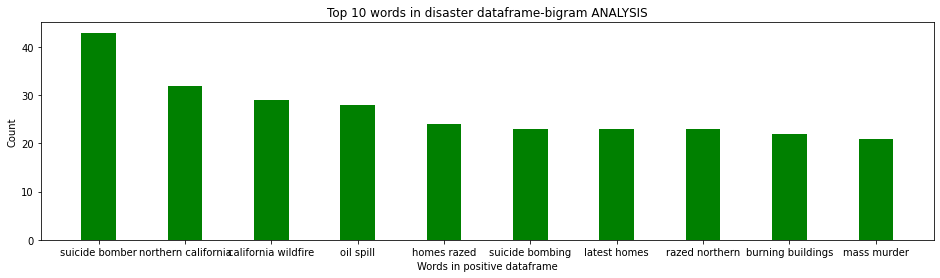

In [285]:
plt.figure(1,figsize=(16,4))
plt.bar(disd1bi,disd2bi, color ='green',
        width = 0.4)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in disaster dataframe-bigram ANALYSIS")
plt.savefig("positive-unigram.png")
plt.show()

<ipython-input-288-0beefcdb0802>:7: UserWarning: Glyph 137 (\x89) missing from current font.
  plt.savefig("negative-bigram.png")
/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


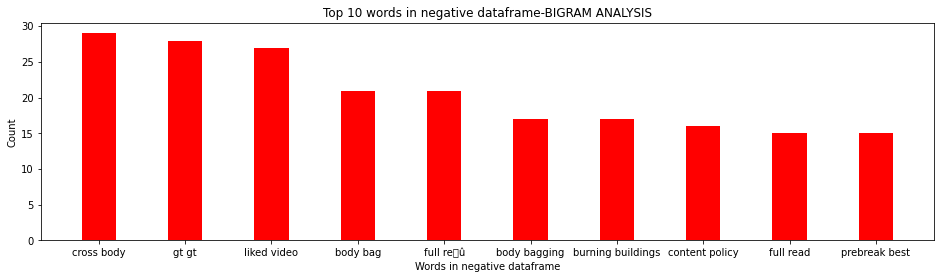

In [288]:
plt.figure(1,figsize=(16,4))
plt.bar(non1,non2, color ='red',
        width = 0.4)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.title("Top 10 words in negative dataframe-BIGRAM ANALYSIS")
plt.savefig("negative-bigram.png")
plt.show()

In [ ]:
X_train_bigr = defaultdict(int)
X_test_bigr = defaultdict(int)
for text in train_df[train_df.target==0].text:
  for word in generate_N_grams(text,2):
    noneValues2[word]+=1


In [ ]:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    ngram_range = (1,2),
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])

mnb = MultinomialNB()
mnb.fit(X_train_cleaned, y_train)
y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test))
print(classification_report(y_test, y_pred))


